<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:12:57] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


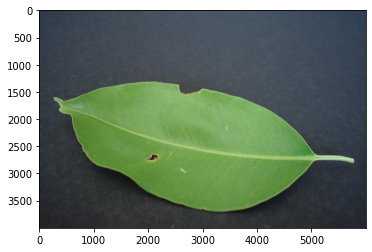

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

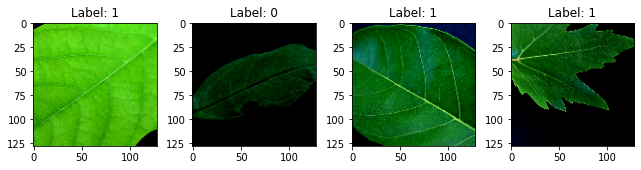

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:13:05] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:13:07] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2596406845563823 samples/sec                   batch loss = 0.36203327775001526 | accuracy = 0.7


Epoch[1] Batch[10] Speed: 1.2770882792558835 samples/sec                   batch loss = 1.3855350017547607 | accuracy = 0.625


Epoch[1] Batch[15] Speed: 1.2729342399120482 samples/sec                   batch loss = 0.7060384750366211 | accuracy = 0.5333333333333333


Epoch[1] Batch[20] Speed: 1.269811629499213 samples/sec                   batch loss = 0.20646224915981293 | accuracy = 0.575


Epoch[1] Batch[25] Speed: 1.2699176452697973 samples/sec                   batch loss = 0.6329696774482727 | accuracy = 0.58


Epoch[1] Batch[30] Speed: 1.2758337223066583 samples/sec                   batch loss = 0.7298582792282104 | accuracy = 0.6083333333333333


Epoch[1] Batch[35] Speed: 1.2712761737481857 samples/sec                   batch loss = 1.197113275527954 | accuracy = 0.6


Epoch[1] Batch[40] Speed: 1.2710811361623495 samples/sec                   batch loss = 1.2052206993103027 | accuracy = 0.58125


Epoch[1] Batch[45] Speed: 1.27576222142345 samples/sec                   batch loss = 0.7525601983070374 | accuracy = 0.5888888888888889


Epoch[1] Batch[50] Speed: 1.2733802143534978 samples/sec                   batch loss = 0.6362767219543457 | accuracy = 0.595


Epoch[1] Batch[55] Speed: 1.2760811752725927 samples/sec                   batch loss = 0.34354880452156067 | accuracy = 0.6090909090909091


Epoch[1] Batch[60] Speed: 1.2776769775351227 samples/sec                   batch loss = 2.185697555541992 | accuracy = 0.6166666666666667


Epoch[1] Batch[65] Speed: 1.2701439611704495 samples/sec                   batch loss = 0.7129261493682861 | accuracy = 0.6153846153846154


Epoch[1] Batch[70] Speed: 1.2741182652378276 samples/sec                   batch loss = 0.7670671939849854 | accuracy = 0.6107142857142858


Epoch[1] Batch[75] Speed: 1.27399626151419 samples/sec                   batch loss = 0.4051666855812073 | accuracy = 0.62


Epoch[1] Batch[80] Speed: 1.27674880638803 samples/sec                   batch loss = 0.41591691970825195 | accuracy = 0.63125


Epoch[1] Batch[85] Speed: 1.2759784949017037 samples/sec                   batch loss = 0.5650050640106201 | accuracy = 0.6441176470588236


Epoch[1] Batch[90] Speed: 1.2755356447066561 samples/sec                   batch loss = 1.18832528591156 | accuracy = 0.6333333333333333


Epoch[1] Batch[95] Speed: 1.281735259413016 samples/sec                   batch loss = 0.64847332239151 | accuracy = 0.6394736842105263


Epoch[1] Batch[100] Speed: 1.2723951595759566 samples/sec                   batch loss = 0.3197205662727356 | accuracy = 0.635


Epoch[1] Batch[105] Speed: 1.2771703318453378 samples/sec                   batch loss = 0.7630018591880798 | accuracy = 0.6285714285714286


Epoch[1] Batch[110] Speed: 1.2803125763125762 samples/sec                   batch loss = 0.5719300508499146 | accuracy = 0.6295454545454545


Epoch[1] Batch[115] Speed: 1.274372893859481 samples/sec                   batch loss = 0.7973300218582153 | accuracy = 0.6260869565217392


Epoch[1] Batch[120] Speed: 1.2766197899010836 samples/sec                   batch loss = 0.8341177105903625 | accuracy = 0.625


Epoch[1] Batch[125] Speed: 1.2732905306184217 samples/sec                   batch loss = 0.5523925423622131 | accuracy = 0.624


Epoch[1] Batch[130] Speed: 1.2733648473856547 samples/sec                   batch loss = 0.5696443319320679 | accuracy = 0.6288461538461538


Epoch[1] Batch[135] Speed: 1.2753181641067133 samples/sec                   batch loss = 0.528745174407959 | accuracy = 0.6314814814814815


Epoch[1] Batch[140] Speed: 1.2760060558740016 samples/sec                   batch loss = 0.534420907497406 | accuracy = 0.6285714285714286


Epoch[1] Batch[145] Speed: 1.2716238261203194 samples/sec                   batch loss = 0.43205466866493225 | accuracy = 0.6310344827586207


Epoch[1] Batch[150] Speed: 1.274427587929396 samples/sec                   batch loss = 0.5868642926216125 | accuracy = 0.6283333333333333


Epoch[1] Batch[155] Speed: 1.2756533847187101 samples/sec                   batch loss = 0.5539056658744812 | accuracy = 0.6209677419354839


Epoch[1] Batch[160] Speed: 1.277061254763323 samples/sec                   batch loss = 0.8657145500183105 | accuracy = 0.6234375


Epoch[1] Batch[165] Speed: 1.2721082354015194 samples/sec                   batch loss = 0.7216268181800842 | accuracy = 0.6196969696969697


Epoch[1] Batch[170] Speed: 1.273693916851793 samples/sec                   batch loss = 0.6760913133621216 | accuracy = 0.6205882352941177


Epoch[1] Batch[175] Speed: 1.2782868662191769 samples/sec                   batch loss = 0.4568144977092743 | accuracy = 0.6242857142857143


Epoch[1] Batch[180] Speed: 1.268274326238411 samples/sec                   batch loss = 0.7781091928482056 | accuracy = 0.625


Epoch[1] Batch[185] Speed: 1.2682332929593283 samples/sec                   batch loss = 0.5270807147026062 | accuracy = 0.6270270270270271


Epoch[1] Batch[190] Speed: 1.277986083789012 samples/sec                   batch loss = 2.0305933952331543 | accuracy = 0.6263157894736842


Epoch[1] Batch[195] Speed: 1.2733062823426409 samples/sec                   batch loss = 0.580664873123169 | accuracy = 0.6269230769230769


Epoch[1] Batch[200] Speed: 1.2731485894086814 samples/sec                   batch loss = 0.7916277050971985 | accuracy = 0.63


Epoch[1] Batch[205] Speed: 1.2737978739534124 samples/sec                   batch loss = 0.6078459620475769 | accuracy = 0.6304878048780488


Epoch[1] Batch[210] Speed: 1.27247786484346 samples/sec                   batch loss = 0.25856903195381165 | accuracy = 0.6309523809523809


Epoch[1] Batch[215] Speed: 1.2750662585878905 samples/sec                   batch loss = 0.6847286820411682 | accuracy = 0.6325581395348837


Epoch[1] Batch[220] Speed: 1.2745199492811858 samples/sec                   batch loss = 0.6502668857574463 | accuracy = 0.6352272727272728


Epoch[1] Batch[225] Speed: 1.275148633050208 samples/sec                   batch loss = 0.541324257850647 | accuracy = 0.6322222222222222


Epoch[1] Batch[230] Speed: 1.2784346315458923 samples/sec                   batch loss = 0.8989174962043762 | accuracy = 0.633695652173913


Epoch[1] Batch[235] Speed: 1.2812567992147448 samples/sec                   batch loss = 0.7101438045501709 | accuracy = 0.6340425531914894


Epoch[1] Batch[240] Speed: 1.2795164913039072 samples/sec                   batch loss = 0.7862237095832825 | accuracy = 0.6375


Epoch[1] Batch[245] Speed: 1.274429524088702 samples/sec                   batch loss = 1.2226588726043701 | accuracy = 0.6346938775510204


Epoch[1] Batch[250] Speed: 1.278687869884495 samples/sec                   batch loss = 0.5162566900253296 | accuracy = 0.634


Epoch[1] Batch[255] Speed: 1.2788761828709176 samples/sec                   batch loss = 0.5839349031448364 | accuracy = 0.6372549019607843


Epoch[1] Batch[260] Speed: 1.2727962405161704 samples/sec                   batch loss = 0.4397611916065216 | accuracy = 0.6394230769230769


Epoch[1] Batch[265] Speed: 1.2738143152351076 samples/sec                   batch loss = 0.9900743961334229 | accuracy = 0.6386792452830189


Epoch[1] Batch[270] Speed: 1.2757277835592993 samples/sec                   batch loss = 0.36216437816619873 | accuracy = 0.6407407407407407


Epoch[1] Batch[275] Speed: 1.2737090983657149 samples/sec                   batch loss = 0.5330899953842163 | accuracy = 0.6445454545454545


Epoch[1] Batch[280] Speed: 1.2696646015679252 samples/sec                   batch loss = 0.9174953699111938 | accuracy = 0.6446428571428572


Epoch[1] Batch[285] Speed: 1.2777054876885061 samples/sec                   batch loss = 0.472528338432312 | accuracy = 0.6482456140350877


Epoch[1] Batch[290] Speed: 1.2781194661023114 samples/sec                   batch loss = 0.4979459047317505 | accuracy = 0.6525862068965518


Epoch[1] Batch[295] Speed: 1.272779728947002 samples/sec                   batch loss = 0.7396658658981323 | accuracy = 0.6516949152542373


Epoch[1] Batch[300] Speed: 1.2624572457882388 samples/sec                   batch loss = 0.380906879901886 | accuracy = 0.6525


Epoch[1] Batch[305] Speed: 1.2681858395573946 samples/sec                   batch loss = 0.503753662109375 | accuracy = 0.65


Epoch[1] Batch[310] Speed: 1.2667587220013459 samples/sec                   batch loss = 0.4267747700214386 | accuracy = 0.6516129032258065


Epoch[1] Batch[315] Speed: 1.2653752769504796 samples/sec                   batch loss = 0.6404842734336853 | accuracy = 0.6515873015873016


Epoch[1] Batch[320] Speed: 1.2655664670315392 samples/sec                   batch loss = 1.0720995664596558 | accuracy = 0.65234375


Epoch[1] Batch[325] Speed: 1.2641672389517336 samples/sec                   batch loss = 0.48566269874572754 | accuracy = 0.6523076923076923


Epoch[1] Batch[330] Speed: 1.2669106264470325 samples/sec                   batch loss = 0.9981417655944824 | accuracy = 0.6537878787878788


Epoch[1] Batch[335] Speed: 1.2672293806714243 samples/sec                   batch loss = 0.5501033067703247 | accuracy = 0.6544776119402985


Epoch[1] Batch[340] Speed: 1.2624113635274286 samples/sec                   batch loss = 1.2525553703308105 | accuracy = 0.6558823529411765


Epoch[1] Batch[345] Speed: 1.2623595956227527 samples/sec                   batch loss = 0.4671616554260254 | accuracy = 0.6572463768115943


Epoch[1] Batch[350] Speed: 1.270162039155797 samples/sec                   batch loss = 0.7653005123138428 | accuracy = 0.6578571428571428


Epoch[1] Batch[355] Speed: 1.2604856109121774 samples/sec                   batch loss = 0.4881007671356201 | accuracy = 0.6619718309859155


Epoch[1] Batch[360] Speed: 1.2714831234899107 samples/sec                   batch loss = 0.5043147802352905 | accuracy = 0.6604166666666667


Epoch[1] Batch[365] Speed: 1.2642768873160757 samples/sec                   batch loss = 0.5493196845054626 | accuracy = 0.6589041095890411


Epoch[1] Batch[370] Speed: 1.2700912687024153 samples/sec                   batch loss = 0.26715803146362305 | accuracy = 0.6567567567567567


Epoch[1] Batch[375] Speed: 1.2694316368375131 samples/sec                   batch loss = 0.5354883670806885 | accuracy = 0.6593333333333333


Epoch[1] Batch[380] Speed: 1.268331470461608 samples/sec                   batch loss = 0.31038209795951843 | accuracy = 0.6598684210526315


Epoch[1] Batch[385] Speed: 1.2623845766686914 samples/sec                   batch loss = 0.32849201560020447 | accuracy = 0.6610389610389611


Epoch[1] Batch[390] Speed: 1.2677011555222684 samples/sec                   batch loss = 1.0428550243377686 | accuracy = 0.6615384615384615


Epoch[1] Batch[395] Speed: 1.2661310199690976 samples/sec                   batch loss = 0.63104248046875 | accuracy = 0.6632911392405063


Epoch[1] Batch[400] Speed: 1.2662724519510247 samples/sec                   batch loss = 0.20146356523036957 | accuracy = 0.664375


Epoch[1] Batch[405] Speed: 1.2632741850228226 samples/sec                   batch loss = 0.4586065411567688 | accuracy = 0.6641975308641975


Epoch[1] Batch[410] Speed: 1.2675390061464689 samples/sec                   batch loss = 0.3298754394054413 | accuracy = 0.6664634146341464


Epoch[1] Batch[415] Speed: 1.2659071824386672 samples/sec                   batch loss = 0.5017157793045044 | accuracy = 0.6662650602409639


Epoch[1] Batch[420] Speed: 1.2648503979511754 samples/sec                   batch loss = 0.6514500975608826 | accuracy = 0.6642857142857143


Epoch[1] Batch[425] Speed: 1.273205690610523 samples/sec                   batch loss = 0.7643527388572693 | accuracy = 0.6652941176470588


Epoch[1] Batch[430] Speed: 1.2651843354444101 samples/sec                   batch loss = 0.3625536262989044 | accuracy = 0.6662790697674419


Epoch[1] Batch[435] Speed: 1.2725650210004278 samples/sec                   batch loss = 0.4050336480140686 | accuracy = 0.6655172413793103


Epoch[1] Batch[440] Speed: 1.2663078148836842 samples/sec                   batch loss = 0.3465949296951294 | accuracy = 0.6664772727272728


Epoch[1] Batch[445] Speed: 1.2619597485379936 samples/sec                   batch loss = 0.6350855827331543 | accuracy = 0.6674157303370787


Epoch[1] Batch[450] Speed: 1.2656598399466736 samples/sec                   batch loss = 0.571413516998291 | accuracy = 0.6666666666666666


Epoch[1] Batch[455] Speed: 1.2640166582548145 samples/sec                   batch loss = 0.433264821767807 | accuracy = 0.6675824175824175


Epoch[1] Batch[460] Speed: 1.2726139610864435 samples/sec                   batch loss = 0.5582249164581299 | accuracy = 0.6690217391304348


Epoch[1] Batch[465] Speed: 1.270019256323482 samples/sec                   batch loss = 0.5615434050559998 | accuracy = 0.6682795698924732


Epoch[1] Batch[470] Speed: 1.2667606349290723 samples/sec                   batch loss = 0.49967554211616516 | accuracy = 0.6691489361702128


Epoch[1] Batch[475] Speed: 1.2680284538989124 samples/sec                   batch loss = 0.47440531849861145 | accuracy = 0.67


Epoch[1] Batch[480] Speed: 1.268364647155054 samples/sec                   batch loss = 0.587863564491272 | accuracy = 0.6708333333333333


Epoch[1] Batch[485] Speed: 1.2725733222094902 samples/sec                   batch loss = 0.4813331365585327 | accuracy = 0.6726804123711341


Epoch[1] Batch[490] Speed: 1.2644196206277492 samples/sec                   batch loss = 0.30869418382644653 | accuracy = 0.6729591836734694


Epoch[1] Batch[495] Speed: 1.2645996553808674 samples/sec                   batch loss = 1.0862596035003662 | accuracy = 0.6727272727272727


Epoch[1] Batch[500] Speed: 1.2615334987835611 samples/sec                   batch loss = 0.3969908356666565 | accuracy = 0.673


Epoch[1] Batch[505] Speed: 1.2675462842604994 samples/sec                   batch loss = 0.24647855758666992 | accuracy = 0.6732673267326733


Epoch[1] Batch[510] Speed: 1.264879292171292 samples/sec                   batch loss = 0.5113406181335449 | accuracy = 0.6735294117647059


Epoch[1] Batch[515] Speed: 1.263762247929681 samples/sec                   batch loss = 0.6239838600158691 | accuracy = 0.6723300970873787


Epoch[1] Batch[520] Speed: 1.2663627747125321 samples/sec                   batch loss = 0.4041602611541748 | accuracy = 0.6716346153846153


Epoch[1] Batch[525] Speed: 1.2687357498769243 samples/sec                   batch loss = 1.1104166507720947 | accuracy = 0.6723809523809524


Epoch[1] Batch[530] Speed: 1.2667643651547562 samples/sec                   batch loss = 0.6163825392723083 | accuracy = 0.6716981132075471


Epoch[1] Batch[535] Speed: 1.2667426536365323 samples/sec                   batch loss = 0.40409398078918457 | accuracy = 0.6738317757009346


Epoch[1] Batch[540] Speed: 1.2559327780310938 samples/sec                   batch loss = 0.3998902142047882 | accuracy = 0.674537037037037


Epoch[1] Batch[545] Speed: 1.2556254130761333 samples/sec                   batch loss = 0.4594383239746094 | accuracy = 0.6747706422018349


Epoch[1] Batch[550] Speed: 1.262465225652313 samples/sec                   batch loss = 0.7165052890777588 | accuracy = 0.6763636363636364


Epoch[1] Batch[555] Speed: 1.259530136819082 samples/sec                   batch loss = 0.37948358058929443 | accuracy = 0.6765765765765765


Epoch[1] Batch[560] Speed: 1.260569995409201 samples/sec                   batch loss = 0.5767377614974976 | accuracy = 0.6767857142857143


Epoch[1] Batch[565] Speed: 1.2611410003184196 samples/sec                   batch loss = 0.28900498151779175 | accuracy = 0.679646017699115


Epoch[1] Batch[570] Speed: 1.26415714197017 samples/sec                   batch loss = 0.44486483931541443 | accuracy = 0.6802631578947368


Epoch[1] Batch[575] Speed: 1.2634179288571648 samples/sec                   batch loss = 0.5368804335594177 | accuracy = 0.6795652173913044


Epoch[1] Batch[580] Speed: 1.2633412487241187 samples/sec                   batch loss = 0.33391857147216797 | accuracy = 0.6810344827586207


Epoch[1] Batch[585] Speed: 1.2570566446692704 samples/sec                   batch loss = 0.4852570593357086 | accuracy = 0.6816239316239316


Epoch[1] Batch[590] Speed: 1.2590755726048435 samples/sec                   batch loss = 0.5691553950309753 | accuracy = 0.6822033898305084


Epoch[1] Batch[595] Speed: 1.2589145830286512 samples/sec                   batch loss = 0.5100994110107422 | accuracy = 0.6823529411764706


Epoch[1] Batch[600] Speed: 1.2646756303678954 samples/sec                   batch loss = 1.2368451356887817 | accuracy = 0.6829166666666666


Epoch[1] Batch[605] Speed: 1.2597426439808286 samples/sec                   batch loss = 0.5500189661979675 | accuracy = 0.6822314049586777


Epoch[1] Batch[610] Speed: 1.2615846297552074 samples/sec                   batch loss = 0.5968101024627686 | accuracy = 0.6827868852459016


Epoch[1] Batch[615] Speed: 1.2602505114701827 samples/sec                   batch loss = 0.6785314679145813 | accuracy = 0.6821138211382114


Epoch[1] Batch[620] Speed: 1.2592825386965254 samples/sec                   batch loss = 0.6918191313743591 | accuracy = 0.6814516129032258


Epoch[1] Batch[625] Speed: 1.2575614056772504 samples/sec                   batch loss = 0.752169132232666 | accuracy = 0.6812


Epoch[1] Batch[630] Speed: 1.2596747322502988 samples/sec                   batch loss = 0.6255102753639221 | accuracy = 0.6817460317460318


Epoch[1] Batch[635] Speed: 1.2594451351189244 samples/sec                   batch loss = 0.1703428030014038 | accuracy = 0.6834645669291338


Epoch[1] Batch[640] Speed: 1.2549822197557257 samples/sec                   batch loss = 0.4997425675392151 | accuracy = 0.683984375


Epoch[1] Batch[645] Speed: 1.262868149892247 samples/sec                   batch loss = 0.4440833628177643 | accuracy = 0.6848837209302325


Epoch[1] Batch[650] Speed: 1.262180198071794 samples/sec                   batch loss = 0.13670220971107483 | accuracy = 0.6857692307692308


Epoch[1] Batch[655] Speed: 1.2579893140143694 samples/sec                   batch loss = 0.19671691954135895 | accuracy = 0.6858778625954198


Epoch[1] Batch[660] Speed: 1.264406756157507 samples/sec                   batch loss = 0.8683808445930481 | accuracy = 0.6852272727272727


Epoch[1] Batch[665] Speed: 1.2567068382713205 samples/sec                   batch loss = 0.6500677466392517 | accuracy = 0.6845864661654135


Epoch[1] Batch[670] Speed: 1.2567487294469133 samples/sec                   batch loss = 0.44494497776031494 | accuracy = 0.6854477611940298


Epoch[1] Batch[675] Speed: 1.2630684723060914 samples/sec                   batch loss = 0.5066945552825928 | accuracy = 0.6851851851851852


Epoch[1] Batch[680] Speed: 1.2614582802312626 samples/sec                   batch loss = 0.42622485756874084 | accuracy = 0.6856617647058824


Epoch[1] Batch[685] Speed: 1.259843957677838 samples/sec                   batch loss = 0.4858590364456177 | accuracy = 0.6857664233576642


Epoch[1] Batch[690] Speed: 1.2652988361768693 samples/sec                   batch loss = 0.4029739201068878 | accuracy = 0.6858695652173913


Epoch[1] Batch[695] Speed: 1.2650533529401387 samples/sec                   batch loss = 0.22270607948303223 | accuracy = 0.6859712230215828


Epoch[1] Batch[700] Speed: 1.261326930122245 samples/sec                   batch loss = 0.5179761648178101 | accuracy = 0.6867857142857143


Epoch[1] Batch[705] Speed: 1.266324063379847 samples/sec                   batch loss = 0.3126595616340637 | accuracy = 0.6882978723404255


Epoch[1] Batch[710] Speed: 1.2645013876022575 samples/sec                   batch loss = 0.9618392586708069 | accuracy = 0.6887323943661972


Epoch[1] Batch[715] Speed: 1.263256873280334 samples/sec                   batch loss = 0.6125867962837219 | accuracy = 0.6874125874125874


Epoch[1] Batch[720] Speed: 1.264723298131555 samples/sec                   batch loss = 0.6003925800323486 | accuracy = 0.6868055555555556


Epoch[1] Batch[725] Speed: 1.2713429336915711 samples/sec                   batch loss = 0.24650101363658905 | accuracy = 0.6862068965517242


Epoch[1] Batch[730] Speed: 1.2589355546902794 samples/sec                   batch loss = 0.323321133852005 | accuracy = 0.6866438356164384


Epoch[1] Batch[735] Speed: 1.2579039542676786 samples/sec                   batch loss = 0.3075537383556366 | accuracy = 0.6880952380952381


Epoch[1] Batch[740] Speed: 1.2610431745197546 samples/sec                   batch loss = 0.8577125072479248 | accuracy = 0.6881756756756757


Epoch[1] Batch[745] Speed: 1.259917186124553 samples/sec                   batch loss = 0.6384164094924927 | accuracy = 0.688255033557047


Epoch[1] Batch[750] Speed: 1.2609981532105432 samples/sec                   batch loss = 0.8063511252403259 | accuracy = 0.6876666666666666


Epoch[1] Batch[755] Speed: 1.2603297518653984 samples/sec                   batch loss = 0.49519866704940796 | accuracy = 0.6887417218543046


Epoch[1] Batch[760] Speed: 1.261568597520283 samples/sec                   batch loss = 0.504768967628479 | accuracy = 0.6881578947368421


Epoch[1] Batch[765] Speed: 1.2585064360632277 samples/sec                   batch loss = 0.41686326265335083 | accuracy = 0.688562091503268


Epoch[1] Batch[770] Speed: 1.2586136882922827 samples/sec                   batch loss = 0.3916764259338379 | accuracy = 0.6886363636363636


Epoch[1] Batch[775] Speed: 1.262273831723316 samples/sec                   batch loss = 0.6302871704101562 | accuracy = 0.6887096774193548


Epoch[1] Batch[780] Speed: 1.2644641241846508 samples/sec                   batch loss = 0.720934271812439 | accuracy = 0.6884615384615385


Epoch[1] Batch[785] Speed: 1.2605904539584976 samples/sec                   batch loss = 0.546271026134491 | accuracy = 0.6888535031847134


[Epoch 1] training: accuracy=0.6890862944162437
[Epoch 1] time cost: 649.8071918487549
[Epoch 1] validation: validation accuracy=0.7244444444444444


Epoch[2] Batch[5] Speed: 1.2716462835996198 samples/sec                   batch loss = 0.8874654769897461 | accuracy = 0.6


Epoch[2] Batch[10] Speed: 1.270496286097207 samples/sec                   batch loss = 0.4103485941886902 | accuracy = 0.65


Epoch[2] Batch[15] Speed: 1.2717794062321315 samples/sec                   batch loss = 0.6550848484039307 | accuracy = 0.6666666666666666


Epoch[2] Batch[20] Speed: 1.2669883145866485 samples/sec                   batch loss = 0.48638126254081726 | accuracy = 0.6625


Epoch[2] Batch[25] Speed: 1.268752060740808 samples/sec                   batch loss = 0.9122006893157959 | accuracy = 0.65


Epoch[2] Batch[30] Speed: 1.2728455846589222 samples/sec                   batch loss = 0.20886005461215973 | accuracy = 0.7


Epoch[2] Batch[35] Speed: 1.2677390889473346 samples/sec                   batch loss = 0.6903820633888245 | accuracy = 0.7285714285714285


Epoch[2] Batch[40] Speed: 1.2668040599426114 samples/sec                   batch loss = 0.5457766056060791 | accuracy = 0.73125


Epoch[2] Batch[45] Speed: 1.2734370463623943 samples/sec                   batch loss = 0.5912609100341797 | accuracy = 0.7277777777777777


Epoch[2] Batch[50] Speed: 1.2647747833525305 samples/sec                   batch loss = 0.38372379541397095 | accuracy = 0.73


Epoch[2] Batch[55] Speed: 1.269242349919339 samples/sec                   batch loss = 0.3666701018810272 | accuracy = 0.740909090909091


Epoch[2] Batch[60] Speed: 1.2731061774486983 samples/sec                   batch loss = 0.7484676241874695 | accuracy = 0.7375


Epoch[2] Batch[65] Speed: 1.2683214027331646 samples/sec                   batch loss = 0.9186118841171265 | accuracy = 0.7230769230769231


Epoch[2] Batch[70] Speed: 1.269845460351465 samples/sec                   batch loss = 0.7691428661346436 | accuracy = 0.725


Epoch[2] Batch[75] Speed: 1.2691216621686565 samples/sec                   batch loss = 0.5708488821983337 | accuracy = 0.73


Epoch[2] Batch[80] Speed: 1.268867688004904 samples/sec                   batch loss = 0.6394275426864624 | accuracy = 0.73125


Epoch[2] Batch[85] Speed: 1.2685219244599135 samples/sec                   batch loss = 0.31002163887023926 | accuracy = 0.7352941176470589


Epoch[2] Batch[90] Speed: 1.2726449487675406 samples/sec                   batch loss = 0.6650256514549255 | accuracy = 0.7388888888888889


Epoch[2] Batch[95] Speed: 1.2668074078095553 samples/sec                   batch loss = 0.6237695813179016 | accuracy = 0.7447368421052631


Epoch[2] Batch[100] Speed: 1.2681694473892577 samples/sec                   batch loss = 0.6362116932868958 | accuracy = 0.745


Epoch[2] Batch[105] Speed: 1.2719552749376635 samples/sec                   batch loss = 0.2148319035768509 | accuracy = 0.7428571428571429


Epoch[2] Batch[110] Speed: 1.2710673654000022 samples/sec                   batch loss = 0.7517279386520386 | accuracy = 0.7386363636363636


Epoch[2] Batch[115] Speed: 1.2680678445731786 samples/sec                   batch loss = 0.18921604752540588 | accuracy = 0.7369565217391304


Epoch[2] Batch[120] Speed: 1.2702163723687092 samples/sec                   batch loss = 0.24476775527000427 | accuracy = 0.7395833333333334


Epoch[2] Batch[125] Speed: 1.2623857165118633 samples/sec                   batch loss = 0.578292191028595 | accuracy = 0.742


Epoch[2] Batch[130] Speed: 1.268849454920576 samples/sec                   batch loss = 0.8518315553665161 | accuracy = 0.7403846153846154


Epoch[2] Batch[135] Speed: 1.263279226443632 samples/sec                   batch loss = 0.4180868864059448 | accuracy = 0.7425925925925926


Epoch[2] Batch[140] Speed: 1.2701891570987305 samples/sec                   batch loss = 0.9068659543991089 | accuracy = 0.7410714285714286


Epoch[2] Batch[145] Speed: 1.2678290462189792 samples/sec                   batch loss = 0.4469980299472809 | accuracy = 0.746551724137931


Epoch[2] Batch[150] Speed: 1.2709149439553193 samples/sec                   batch loss = 1.0232504606246948 | accuracy = 0.745


Epoch[2] Batch[155] Speed: 1.2669122528252188 samples/sec                   batch loss = 0.21339116990566254 | accuracy = 0.7467741935483871


Epoch[2] Batch[160] Speed: 1.2698817920808596 samples/sec                   batch loss = 0.9544659852981567 | accuracy = 0.7453125


Epoch[2] Batch[165] Speed: 1.268219296233149 samples/sec                   batch loss = 0.6953492760658264 | accuracy = 0.7424242424242424


Epoch[2] Batch[170] Speed: 1.2679849449037894 samples/sec                   batch loss = 0.3485967516899109 | accuracy = 0.7470588235294118


Epoch[2] Batch[175] Speed: 1.2664683109582409 samples/sec                   batch loss = 0.3917063772678375 | accuracy = 0.7471428571428571


Epoch[2] Batch[180] Speed: 1.266319284367102 samples/sec                   batch loss = 0.7658471465110779 | accuracy = 0.7486111111111111


Epoch[2] Batch[185] Speed: 1.2720810354547174 samples/sec                   batch loss = 0.4228157699108124 | accuracy = 0.7472972972972973


Epoch[2] Batch[190] Speed: 1.264723774827338 samples/sec                   batch loss = 0.3145514726638794 | accuracy = 0.7473684210526316


Epoch[2] Batch[195] Speed: 1.272424882051744 samples/sec                   batch loss = 0.36428436636924744 | accuracy = 0.7474358974358974


Epoch[2] Batch[200] Speed: 1.2672271791766823 samples/sec                   batch loss = 0.5576489567756653 | accuracy = 0.74625


Epoch[2] Batch[205] Speed: 1.2716350065688042 samples/sec                   batch loss = 0.7006257772445679 | accuracy = 0.7426829268292683


Epoch[2] Batch[210] Speed: 1.270184252704132 samples/sec                   batch loss = 0.6300625801086426 | accuracy = 0.7440476190476191


Epoch[2] Batch[215] Speed: 1.2658010711751753 samples/sec                   batch loss = 0.9184514880180359 | accuracy = 0.7406976744186047


Epoch[2] Batch[220] Speed: 1.2737717622018618 samples/sec                   batch loss = 0.20713922381401062 | accuracy = 0.7443181818181818


Epoch[2] Batch[225] Speed: 1.2673426243905284 samples/sec                   batch loss = 0.12258222699165344 | accuracy = 0.7455555555555555


Epoch[2] Batch[230] Speed: 1.267557488888899 samples/sec                   batch loss = 0.4489663541316986 | accuracy = 0.741304347826087


Epoch[2] Batch[235] Speed: 1.2694934001872624 samples/sec                   batch loss = 0.6326193809509277 | accuracy = 0.7414893617021276


Epoch[2] Batch[240] Speed: 1.2724306723060324 samples/sec                   batch loss = 1.0416988134384155 | accuracy = 0.740625


Epoch[2] Batch[245] Speed: 1.2642790785719324 samples/sec                   batch loss = 0.1818016767501831 | accuracy = 0.7438775510204082


Epoch[2] Batch[250] Speed: 1.2677397595080957 samples/sec                   batch loss = 0.36931344866752625 | accuracy = 0.745


Epoch[2] Batch[255] Speed: 1.2705137968282472 samples/sec                   batch loss = 0.8569685816764832 | accuracy = 0.7450980392156863


Epoch[2] Batch[260] Speed: 1.2698509388124712 samples/sec                   batch loss = 0.38759857416152954 | accuracy = 0.7461538461538462


Epoch[2] Batch[265] Speed: 1.269200773902173 samples/sec                   batch loss = 0.35252639651298523 | accuracy = 0.7462264150943396


Epoch[2] Batch[270] Speed: 1.2659888553365455 samples/sec                   batch loss = 0.41467365622520447 | accuracy = 0.7453703703703703


Epoch[2] Batch[275] Speed: 1.2763992204608337 samples/sec                   batch loss = 0.6898643970489502 | accuracy = 0.7463636363636363


Epoch[2] Batch[280] Speed: 1.275836341894186 samples/sec                   batch loss = 0.2809879779815674 | accuracy = 0.7473214285714286


Epoch[2] Batch[285] Speed: 1.2716074413354792 samples/sec                   batch loss = 0.7700305581092834 | accuracy = 0.7464912280701754


Epoch[2] Batch[290] Speed: 1.2803244963055975 samples/sec                   batch loss = 0.7594115734100342 | accuracy = 0.7448275862068966


Epoch[2] Batch[295] Speed: 1.2783239747995812 samples/sec                   batch loss = 0.3376079499721527 | accuracy = 0.7466101694915255


Epoch[2] Batch[300] Speed: 1.274610580977755 samples/sec                   batch loss = 0.623572826385498 | accuracy = 0.7425


Epoch[2] Batch[305] Speed: 1.2777674749036585 samples/sec                   batch loss = 0.7554658651351929 | accuracy = 0.7418032786885246


Epoch[2] Batch[310] Speed: 1.2695527678270095 samples/sec                   batch loss = 0.3267461061477661 | accuracy = 0.742741935483871


Epoch[2] Batch[315] Speed: 1.2677710850656871 samples/sec                   batch loss = 2.1038856506347656 | accuracy = 0.7420634920634921


Epoch[2] Batch[320] Speed: 1.2686262860488975 samples/sec                   batch loss = 0.29772868752479553 | accuracy = 0.74375


Epoch[2] Batch[325] Speed: 1.267015105809541 samples/sec                   batch loss = 0.6197104454040527 | accuracy = 0.7430769230769231


Epoch[2] Batch[330] Speed: 1.2680969818289642 samples/sec                   batch loss = 0.759211540222168 | accuracy = 0.7439393939393939


Epoch[2] Batch[335] Speed: 1.26622619639363 samples/sec                   batch loss = 0.5356809496879578 | accuracy = 0.7425373134328358


Epoch[2] Batch[340] Speed: 1.2696319333179762 samples/sec                   batch loss = 0.7736067771911621 | accuracy = 0.7404411764705883


Epoch[2] Batch[345] Speed: 1.2683453737779378 samples/sec                   batch loss = 0.9734802842140198 | accuracy = 0.741304347826087


Epoch[2] Batch[350] Speed: 1.2704539544556792 samples/sec                   batch loss = 0.7777826189994812 | accuracy = 0.7428571428571429


Epoch[2] Batch[355] Speed: 1.2713743412271148 samples/sec                   batch loss = 0.8503875136375427 | accuracy = 0.7436619718309859


Epoch[2] Batch[360] Speed: 1.2742477443857148 samples/sec                   batch loss = 0.37975674867630005 | accuracy = 0.7416666666666667


Epoch[2] Batch[365] Speed: 1.2688792998738323 samples/sec                   batch loss = 0.29803553223609924 | accuracy = 0.7431506849315068


Epoch[2] Batch[370] Speed: 1.2641732400643644 samples/sec                   batch loss = 0.182974711060524 | accuracy = 0.7412162162162163


Epoch[2] Batch[375] Speed: 1.273976139433477 samples/sec                   batch loss = 0.5078619718551636 | accuracy = 0.7406666666666667


Epoch[2] Batch[380] Speed: 1.2725256399958527 samples/sec                   batch loss = 0.16962528228759766 | accuracy = 0.7427631578947368


Epoch[2] Batch[385] Speed: 1.2745921824753086 samples/sec                   batch loss = 0.24904677271842957 | accuracy = 0.7415584415584415


Epoch[2] Batch[390] Speed: 1.2728606493865242 samples/sec                   batch loss = 2.0093510150909424 | accuracy = 0.7416666666666667


Epoch[2] Batch[395] Speed: 1.2725845193607168 samples/sec                   batch loss = 0.38417133688926697 | accuracy = 0.739240506329114


Epoch[2] Batch[400] Speed: 1.2692231458777596 samples/sec                   batch loss = 0.10093968361616135 | accuracy = 0.738125


Epoch[2] Batch[405] Speed: 1.2718908612364996 samples/sec                   batch loss = 0.4636823832988739 | accuracy = 0.7358024691358025


Epoch[2] Batch[410] Speed: 1.2724358835799485 samples/sec                   batch loss = 0.40513914823532104 | accuracy = 0.7365853658536585


Epoch[2] Batch[415] Speed: 1.271540364501524 samples/sec                   batch loss = 0.30427974462509155 | accuracy = 0.7367469879518073


Epoch[2] Batch[420] Speed: 1.2637114162281295 samples/sec                   batch loss = 0.6846808195114136 | accuracy = 0.7351190476190477


Epoch[2] Batch[425] Speed: 1.2686590944339198 samples/sec                   batch loss = 0.33516478538513184 | accuracy = 0.7358823529411764


Epoch[2] Batch[430] Speed: 1.2669250726582784 samples/sec                   batch loss = 0.24055907130241394 | accuracy = 0.7366279069767442


Epoch[2] Batch[435] Speed: 1.26940781680934 samples/sec                   batch loss = 0.5126954913139343 | accuracy = 0.7367816091954023


Epoch[2] Batch[440] Speed: 1.2659699406751652 samples/sec                   batch loss = 0.7082980275154114 | accuracy = 0.7369318181818182


Epoch[2] Batch[445] Speed: 1.265356857792147 samples/sec                   batch loss = 0.724931538105011 | accuracy = 0.7353932584269663


Epoch[2] Batch[450] Speed: 1.26596860329626 samples/sec                   batch loss = 0.46506577730178833 | accuracy = 0.735


Epoch[2] Batch[455] Speed: 1.2704108560461373 samples/sec                   batch loss = 0.19509445130825043 | accuracy = 0.7373626373626374


Epoch[2] Batch[460] Speed: 1.2659594327741714 samples/sec                   batch loss = 0.4613824486732483 | accuracy = 0.7385869565217391


Epoch[2] Batch[465] Speed: 1.2646907883270928 samples/sec                   batch loss = 0.540429413318634 | accuracy = 0.7381720430107527


Epoch[2] Batch[470] Speed: 1.265436264415677 samples/sec                   batch loss = 0.5720111131668091 | accuracy = 0.7398936170212767


Epoch[2] Batch[475] Speed: 1.2693367462317784 samples/sec                   batch loss = 0.5044652223587036 | accuracy = 0.738421052631579


Epoch[2] Batch[480] Speed: 1.2665746297428842 samples/sec                   batch loss = 0.5405817031860352 | accuracy = 0.7375


Epoch[2] Batch[485] Speed: 1.2646109032975943 samples/sec                   batch loss = 0.5090766549110413 | accuracy = 0.7376288659793815


Epoch[2] Batch[490] Speed: 1.2673164894281996 samples/sec                   batch loss = 0.8463141918182373 | accuracy = 0.736734693877551


Epoch[2] Batch[495] Speed: 1.2604349477591488 samples/sec                   batch loss = 0.39227014780044556 | accuracy = 0.7373737373737373


Epoch[2] Batch[500] Speed: 1.2647962367651184 samples/sec                   batch loss = 0.5908004641532898 | accuracy = 0.737


Epoch[2] Batch[505] Speed: 1.2613348008745102 samples/sec                   batch loss = 0.31987813115119934 | accuracy = 0.7351485148514851


Epoch[2] Batch[510] Speed: 1.2650376139693582 samples/sec                   batch loss = 0.2089819610118866 | accuracy = 0.7352941176470589


Epoch[2] Batch[515] Speed: 1.2638466908991854 samples/sec                   batch loss = 0.6581063866615295 | accuracy = 0.7349514563106796


Epoch[2] Batch[520] Speed: 1.2660837237550608 samples/sec                   batch loss = 0.24122345447540283 | accuracy = 0.7365384615384616


Epoch[2] Batch[525] Speed: 1.2612868192600837 samples/sec                   batch loss = 0.695412278175354 | accuracy = 0.7366666666666667


Epoch[2] Batch[530] Speed: 1.2663534073087963 samples/sec                   batch loss = 0.23487588763237 | accuracy = 0.7363207547169811


Epoch[2] Batch[535] Speed: 1.2631113592580647 samples/sec                   batch loss = 0.7777896523475647 | accuracy = 0.7369158878504672


Epoch[2] Batch[540] Speed: 1.2702021395025433 samples/sec                   batch loss = 0.41510534286499023 | accuracy = 0.737037037037037


Epoch[2] Batch[545] Speed: 1.265463658195101 samples/sec                   batch loss = 0.8521156311035156 | accuracy = 0.7362385321100917


Epoch[2] Batch[550] Speed: 1.2719970316155087 samples/sec                   batch loss = 0.8869047164916992 | accuracy = 0.7368181818181818


Epoch[2] Batch[555] Speed: 1.2731768978245628 samples/sec                   batch loss = 0.560947835445404 | accuracy = 0.7360360360360361


Epoch[2] Batch[560] Speed: 1.270386710670634 samples/sec                   batch loss = 0.9565509557723999 | accuracy = 0.7366071428571429


Epoch[2] Batch[565] Speed: 1.2761154380901825 samples/sec                   batch loss = 0.5691928863525391 | accuracy = 0.7371681415929203


Epoch[2] Batch[570] Speed: 1.2746835992188645 samples/sec                   batch loss = 0.5342082381248474 | accuracy = 0.7364035087719298


Epoch[2] Batch[575] Speed: 1.2720294359152435 samples/sec                   batch loss = 0.9210907816886902 | accuracy = 0.7360869565217392


Epoch[2] Batch[580] Speed: 1.2663402167099354 samples/sec                   batch loss = 0.598457932472229 | accuracy = 0.7370689655172413


Epoch[2] Batch[585] Speed: 1.2722431913457335 samples/sec                   batch loss = 0.6134753823280334 | accuracy = 0.735897435897436


Epoch[2] Batch[590] Speed: 1.2703765140944707 samples/sec                   batch loss = 0.2710338234901428 | accuracy = 0.7364406779661017


Epoch[2] Batch[595] Speed: 1.2662765615958216 samples/sec                   batch loss = 0.6689172983169556 | accuracy = 0.734873949579832


Epoch[2] Batch[600] Speed: 1.263889154649315 samples/sec                   batch loss = 0.514794647693634 | accuracy = 0.73375


Epoch[2] Batch[605] Speed: 1.2620916102568054 samples/sec                   batch loss = 0.6602936387062073 | accuracy = 0.7326446280991735


Epoch[2] Batch[610] Speed: 1.2676083431536393 samples/sec                   batch loss = 0.8672255873680115 | accuracy = 0.7327868852459016


Epoch[2] Batch[615] Speed: 1.2740245108923631 samples/sec                   batch loss = 0.5081960558891296 | accuracy = 0.7329268292682927


Epoch[2] Batch[620] Speed: 1.274505619808405 samples/sec                   batch loss = 0.4074323773384094 | accuracy = 0.7346774193548387


Epoch[2] Batch[625] Speed: 1.2787483930104118 samples/sec                   batch loss = 0.41625890135765076 | accuracy = 0.734


Epoch[2] Batch[630] Speed: 1.26672553362495 samples/sec                   batch loss = 0.24683313071727753 | accuracy = 0.7345238095238096


Epoch[2] Batch[635] Speed: 1.270353331921932 samples/sec                   batch loss = 0.7189719676971436 | accuracy = 0.7346456692913386


Epoch[2] Batch[640] Speed: 1.2672614467880166 samples/sec                   batch loss = 0.3308763802051544 | accuracy = 0.735546875


Epoch[2] Batch[645] Speed: 1.2705704694809903 samples/sec                   batch loss = 0.2817590832710266 | accuracy = 0.7368217054263566


Epoch[2] Batch[650] Speed: 1.2619498766310757 samples/sec                   batch loss = 0.3112514317035675 | accuracy = 0.7369230769230769


Epoch[2] Batch[655] Speed: 1.2661188850478922 samples/sec                   batch loss = 0.47323372960090637 | accuracy = 0.7377862595419847


Epoch[2] Batch[660] Speed: 1.2661859644523075 samples/sec                   batch loss = 0.6701362133026123 | accuracy = 0.7382575757575758


Epoch[2] Batch[665] Speed: 1.2704132610142775 samples/sec                   batch loss = 0.5041286945343018 | accuracy = 0.7390977443609023


Epoch[2] Batch[670] Speed: 1.2682155574339213 samples/sec                   batch loss = 0.8953083753585815 | accuracy = 0.7388059701492538


Epoch[2] Batch[675] Speed: 1.266745427313253 samples/sec                   batch loss = 0.19395515322685242 | accuracy = 0.7396296296296296


Epoch[2] Batch[680] Speed: 1.2679674079813428 samples/sec                   batch loss = 0.4208553731441498 | accuracy = 0.7393382352941177


Epoch[2] Batch[685] Speed: 1.2700143532408188 samples/sec                   batch loss = 0.7943265438079834 | accuracy = 0.7401459854014598


Epoch[2] Batch[690] Speed: 1.2702804242138361 samples/sec                   batch loss = 0.18386434018611908 | accuracy = 0.7402173913043478


Epoch[2] Batch[695] Speed: 1.2718094855889852 samples/sec                   batch loss = 0.8844529390335083 | accuracy = 0.7399280575539569


Epoch[2] Batch[700] Speed: 1.270289945985547 samples/sec                   batch loss = 0.4283228814601898 | accuracy = 0.74


Epoch[2] Batch[705] Speed: 1.2676385128661727 samples/sec                   batch loss = 0.6320891380310059 | accuracy = 0.7393617021276596


Epoch[2] Batch[710] Speed: 1.2735850460251936 samples/sec                   batch loss = 0.5068891644477844 | accuracy = 0.7390845070422535


Epoch[2] Batch[715] Speed: 1.2664281592265505 samples/sec                   batch loss = 0.25776907801628113 | accuracy = 0.7395104895104895


Epoch[2] Batch[720] Speed: 1.2698702579732777 samples/sec                   batch loss = 0.6584896445274353 | accuracy = 0.740625


Epoch[2] Batch[725] Speed: 1.265404767807588 samples/sec                   batch loss = 0.6601619124412537 | accuracy = 0.7410344827586207


Epoch[2] Batch[730] Speed: 1.2699825321931166 samples/sec                   batch loss = 1.010643482208252 | accuracy = 0.7407534246575342


Epoch[2] Batch[735] Speed: 1.2697139914671354 samples/sec                   batch loss = 0.6820168495178223 | accuracy = 0.7414965986394558


Epoch[2] Batch[740] Speed: 1.2668273997262052 samples/sec                   batch loss = 0.3481161892414093 | accuracy = 0.7415540540540541


Epoch[2] Batch[745] Speed: 1.2703461177255033 samples/sec                   batch loss = 0.20871788263320923 | accuracy = 0.7422818791946308


Epoch[2] Batch[750] Speed: 1.269991280418897 samples/sec                   batch loss = 0.2814458906650543 | accuracy = 0.7416666666666667


Epoch[2] Batch[755] Speed: 1.272435787074488 samples/sec                   batch loss = 0.29380542039871216 | accuracy = 0.7420529801324504


Epoch[2] Batch[760] Speed: 1.274488773407899 samples/sec                   batch loss = 0.10616061091423035 | accuracy = 0.7430921052631579


Epoch[2] Batch[765] Speed: 1.2711229317716484 samples/sec                   batch loss = 0.43238353729248047 | accuracy = 0.7428104575163399


Epoch[2] Batch[770] Speed: 1.2701799253285848 samples/sec                   batch loss = 0.5761024951934814 | accuracy = 0.7422077922077922


Epoch[2] Batch[775] Speed: 1.2782752763167067 samples/sec                   batch loss = 0.08022956550121307 | accuracy = 0.7412903225806452


Epoch[2] Batch[780] Speed: 1.2735767316116395 samples/sec                   batch loss = 0.36780521273612976 | accuracy = 0.7416666666666667


Epoch[2] Batch[785] Speed: 1.2647321647319385 samples/sec                   batch loss = 1.0662870407104492 | accuracy = 0.7417197452229299


[Epoch 2] training: accuracy=0.7420685279187818
[Epoch 2] time cost: 639.0279972553253
[Epoch 2] validation: validation accuracy=0.7944444444444444


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7911111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)